# Fetching Historical Data using yfinance
I am using the top 20 credit service companies from Yahoo Finance.

In [89]:
# import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.rolling import RollingOLS

ticker_list = ['V', 'MA', 'AXP', 'COF', 'PYPL', 'SYF', 'SOFI', 'ALLY', 'UPST', 'OMF', 'SLM', 'CACC', 'FCFS', 'NNI', 'BFH', 'ENVA', 'WU', 'NAVI', 'AGM-A', 'OPFI']
data = yf.download(ticker_list, start='2024-06-16', end='2025-06-16')

/var/folders/sx/1hm8tkl152z03tg5g8wfh9y40000gn/T/ipykernel_88717/2124726713.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker_list, start='2024-06-16', end='2025-06-16')
[*********************100%***********************]  20 of 20 completed


In [90]:
# create a pandas DataFrame of just the closing prices
data_close = pd.DataFrame(data['Close'])

In [91]:
data_close

Ticker,AGM-A,ALLY,AXP,BFH,CACC,COF,ENVA,FCFS,MA,NAVI,NNI,OMF,OPFI,PYPL,SLM,SOFI,SYF,UPST,V,WU
Date,,,,,,,,,,,,,,,,,,,,
2024-06-17,134.286453,38.495434,225.148712,40.024628,482.920013,135.213013,59.860001,107.901718,444.886932,13.654328,98.645676,44.262695,3.353995,60.130001,20.063984,6.46,42.266731,22.389999,269.212921,11.117921
2024-06-18,119.907188,38.785969,226.174500,40.211700,482.540009,135.449692,59.750000,107.862236,446.872528,13.644759,100.229874,44.539337,3.295833,59.119999,20.132698,6.42,42.796410,22.219999,271.645233,11.282090
2024-06-20,121.839165,38.727863,227.062195,43.352623,485.170013,136.228821,60.560001,105.720192,449.255310,13.845698,99.160538,45.138729,3.140735,59.799999,20.289751,6.32,44.071575,21.879999,274.822174,11.127041
2024-06-21,119.234367,38.563225,227.229858,43.283707,488.790009,134.887558,60.430000,104.930496,451.578491,13.903110,99.150635,45.212494,3.247365,60.610001,20.436993,6.32,43.620365,21.639999,273.233704,11.254729
2024-06-24,119.186302,39.124920,228.304962,43.342781,490.420013,135.785004,61.380001,104.673859,453.673279,13.903110,98.972420,45.728897,3.257059,59.490002,20.603867,6.54,44.650295,23.219999,274.305878,11.309452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,131.556549,36.599998,300.800568,51.209999,506.709991,198.990005,97.080002,131.070007,583.540466,13.580000,114.760002,52.869999,13.890000,73.550003,31.840000,14.10,60.830002,57.419998,366.660004,9.027300
2025-06-10,136.977066,36.790001,298.765686,52.270000,510.980011,201.000000,97.089996,131.940002,588.743347,13.760000,115.070000,52.860001,13.930000,74.760002,31.590000,14.39,60.759998,57.680000,370.700012,9.027300
2025-06-11,136.977066,37.400002,298.346771,54.480000,513.150024,200.529999,96.989998,130.740005,589.941772,13.930000,115.870003,53.529999,13.900000,74.610001,31.680000,15.06,61.790001,57.880001,373.309998,8.998116


In [92]:
# export the data to a csv file
data_close.to_csv('/Users/ashleytran/Desktop/URE25/pairs-trading/data/stock_data.csv')

# Computing the Spread of the Time Series

In [93]:
# create combinations of the stocks
pair_list = combinations(ticker_list, 2)
data_spread = {}
spread_stats = []

# for each pair, calculate mean and spread
for ticker1, ticker2 in pair_list:
        # store spread time series
        spread = data_close[ticker1] - data_close[ticker2]
        col_name = f"{ticker1}-{ticker2}"
        data_spread[col_name] = spread
        
        # compute stats
        mean = spread.mean()
        std = spread.std()
        range_value = spread.max() - spread.min()

        spread_stats.append({
                "Ticker 1": ticker1,
                "Ticker 2": ticker2,
                "Mean": mean,
                "Standard Deviation": std,
                "Range": range_value 
        })
data_spread = pd.DataFrame(data_spread)
spread_stats = pd.DataFrame(spread_stats)

In [94]:
data_spread 

,V-MA,V-AXP,V-COF,V-PYPL,V-SYF,V-SOFI,V-ALLY,V-UPST,V-OMF,V-SLM,...,ENVA-WU,ENVA-NAVI,ENVA-AGM-A,ENVA-OPFI,WU-NAVI,WU-AGM-A,WU-OPFI,NAVI-AGM-A,NAVI-OPFI,AGM-A-OPFI
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-17,-175.674011,44.064209,133.999908,209.082920,226.946190,262.752921,230.717487,246.822922,224.950226,249.148937,...,48.742080,46.205672,-74.426453,56.506006,-2.536407,-123.168532,7.763926,-120.632125,10.300333,130.932458
2024-06-18,-175.227295,45.470734,136.195541,212.525234,228.848824,265.225233,232.859264,249.425234,227.105896,251.512535,...,48.467910,46.105241,-60.157188,56.454167,-2.362669,-108.625098,7.986257,-106.262429,10.348926,116.611355
2024-06-20,-174.433136,47.759979,138.593353,215.022175,230.750599,268.502174,236.094311,252.942175,229.683445,254.532423,...,49.432961,46.714303,-61.279163,57.419266,-2.718657,-110.712124,7.986305,-107.993466,10.704963,118.698429
2024-06-21,-178.344788,46.003845,138.346146,212.623703,229.613338,266.913703,234.670479,251.593704,228.021210,252.796711,...,49.175271,46.526891,-58.804367,57.182635,-2.648380,-107.979638,8.007364,-105.331258,10.655745,115.987002
2024-06-24,-179.367401,46.000916,138.520874,214.815876,229.655582,267.765878,235.180958,251.085878,228.576981,253.702011,...,50.070549,47.476892,-57.806301,58.122942,-2.593657,-107.876850,8.052393,-105.283193,10.646051,115.929244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,-216.880463,65.859436,167.669998,293.110001,305.830002,352.560003,330.060005,309.240005,313.790005,334.820004,...,88.052702,83.500002,-34.476547,83.190001,-4.552700,-122.529249,-4.862700,-117.976549,-0.310000,117.666549
2025-06-10,-218.043335,71.934326,169.700012,295.940010,309.940014,356.310012,333.910011,313.020012,317.840012,339.110012,...,88.062696,83.329996,-39.887070,83.159996,-4.732700,-127.949766,-4.902700,-123.217066,-0.170000,123.047066
2025-06-11,-216.631775,74.963226,172.779999,298.699997,311.519997,358.249997,335.909996,315.429996,319.779999,341.629997,...,87.991881,83.059998,-39.987068,83.089998,-4.931884,-127.978950,-4.901883,-123.047066,0.030001,123.077066


In [95]:
spread_stats

,Ticker 1,Ticker 2,Mean,Standard Deviation,Range
0,V,MA,-203.723485,14.460583,59.135742
1,V,AXP,36.640007,25.616554,91.648605
2,V,COF,141.165457,18.328960,71.708267
3,V,PYPL,236.012986,34.302011,108.509918
4,V,SYF,254.348784,31.196935,109.028725
...,...,...,...,...,...
185,WU,AGM-A,-132.182815,10.683849,44.826610
186,WU,OPFI,2.728152,3.935320,14.589092
187,NAVI,AGM-A,-128.624416,10.260566,43.411029
188,NAVI,OPFI,6.286551,4.054612,15.300804


In [96]:
data_spread.to_csv('/Users/ashleytran/Desktop/URE25/pairs-trading/data/data_spread.csv')

In [97]:
spread_stats.to_csv('/Users/ashleytran/Desktop/URE25/pairs-trading/data/spread_stats.csv')

# Compute the Correlation
Use Pearson's r correlation to filter the highest correlated pairs to then test for cointegration. First compute the log returns.

In [98]:
# compute log returns and drop the first day
log_returns = np.log(data_close / data_close.shift(1))
log_returns.dropna()


Ticker,AGM-A,ALLY,AXP,BFH,CACC,COF,ENVA,FCFS,MA,NAVI,NNI,OMF,OPFI,PYPL,SLM,SOFI,SYF,UPST,V,WU
Date,,,,,,,,,,,,,,,,,,,,
2024-06-18,-0.113257,0.007519,0.004546,0.004663,-0.000787,0.001749,-0.001839,-0.000366,0.004453,-0.000701,0.015932,0.006231,-0.017493,-0.016940,0.003419,-0.006211,0.012454,-0.007622,0.008994,0.014658
2024-06-20,0.015984,-0.001499,0.003917,0.075209,0.005436,0.005736,0.013465,-0.020059,0.005318,0.014619,-0.010726,0.013368,-0.048202,0.011436,0.007771,-0.015699,0.029361,-0.015420,0.011627,-0.013838
2024-06-21,-0.021611,-0.004260,0.000738,-0.001591,0.007434,-0.009894,-0.002149,-0.007498,0.005158,0.004138,-0.000100,0.001633,0.033387,0.013454,0.007231,0.000000,-0.010291,-0.011030,-0.005797,0.011410
2024-06-24,-0.000403,0.014461,0.004720,0.001364,0.003329,0.006631,0.015598,-0.002449,0.004628,0.000000,-0.001799,0.011357,0.002981,-0.018652,0.008132,0.034218,0.023337,0.070471,0.003916,0.004850
2024-06-25,-0.012252,-0.017731,-0.003809,-0.015107,-0.000490,-0.020695,-0.014110,-0.004442,-0.002871,-0.015956,-0.000500,-0.028015,0.002972,-0.002693,-0.015847,-0.013857,-0.007940,-0.028836,-0.010076,-0.011354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,0.000000,0.008230,-0.003013,-0.006811,0.002193,0.004281,0.005578,0.041197,-0.009860,0.009619,0.001483,-0.009038,-0.020663,0.001633,-0.010000,-0.009880,0.026824,0.055316,-0.009662,-0.019211
2025-06-10,0.040377,0.005178,-0.006788,0.020488,0.008392,0.010050,0.000103,0.006616,0.008877,0.013168,0.002698,-0.000189,0.002876,0.016318,-0.007883,0.020359,-0.001151,0.004518,0.010958,0.000000
2025-06-11,0.000000,0.016445,-0.001403,0.041411,0.004238,-0.002341,-0.001030,-0.009137,0.002033,0.012279,0.006928,0.012595,-0.002156,-0.002008,0.002845,0.045509,0.016810,0.003461,0.007016,-0.003238


In [99]:
# compute Pearson correlation
corr_matrix = log_returns.corr()
corr_matrix

Ticker,AGM-A,ALLY,AXP,BFH,CACC,COF,ENVA,FCFS,MA,NAVI,NNI,OMF,OPFI,PYPL,SLM,SOFI,SYF,UPST,V,WU
Ticker,,,,,,,,,,,,,,,,,,,,
AGM-A,1.000000,0.139945,0.139209,0.198044,0.184833,0.207936,0.226945,0.109841,0.144991,0.245566,0.283485,0.187146,0.116608,0.039097,0.219954,0.128363,0.195152,0.063744,0.129234,-0.031653
ALLY,0.139945,1.000000,0.724880,0.723175,0.649649,0.695058,0.700534,0.305038,0.451432,0.620998,0.558340,0.709525,0.377358,0.452851,0.618946,0.565301,0.720693,0.454330,0.418765,0.350169
AXP,0.139209,0.724880,1.000000,0.756059,0.581213,0.842906,0.793275,0.260959,0.677370,0.667628,0.625054,0.814764,0.413128,0.636449,0.759009,0.698382,0.846243,0.499223,0.645779,0.423301
BFH,0.198044,0.723175,0.756059,1.000000,0.596431,0.786788,0.759113,0.263059,0.505446,0.660289,0.574493,0.752671,0.354385,0.539454,0.677350,0.585300,0.856539,0.451896,0.514068,0.327058
CACC,0.184833,0.649649,0.581213,0.596431,1.000000,0.623296,0.619325,0.295632,0.432552,0.600942,0.525376,0.675785,0.277861,0.406363,0.577717,0.550543,0.617487,0.414076,0.438540,0.392813
COF,0.207936,0.695058,0.842906,0.786788,0.623296,1.000000,0.797963,0.321165,0.587355,0.674351,0.580112,0.817593,0.370522,0.569431,0.752454,0.642079,0.883427,0.481443,0.559054,0.349587
ENVA,0.226945,0.700534,0.793275,0.759113,0.619325,0.797963,1.000000,0.346867,0.520415,0.713324,0.620233,0.835367,0.414881,0.542552,0.734347,0.668820,0.794760,0.470360,0.472677,0.330221
FCFS,0.109841,0.305038,0.260959,0.263059,0.295632,0.321165,0.346867,1.000000,0.277881,0.329647,0.299453,0.307745,0.150007,0.182867,0.347023,0.224251,0.237417,0.236980,0.267226,0.275296
MA,0.144991,0.451432,0.677370,0.505446,0.432552,0.587355,0.520415,0.277881,1.000000,0.526377,0.506872,0.558406,0.320813,0.551513,0.513121,0.496536,0.544255,0.370307,0.880869,0.435055


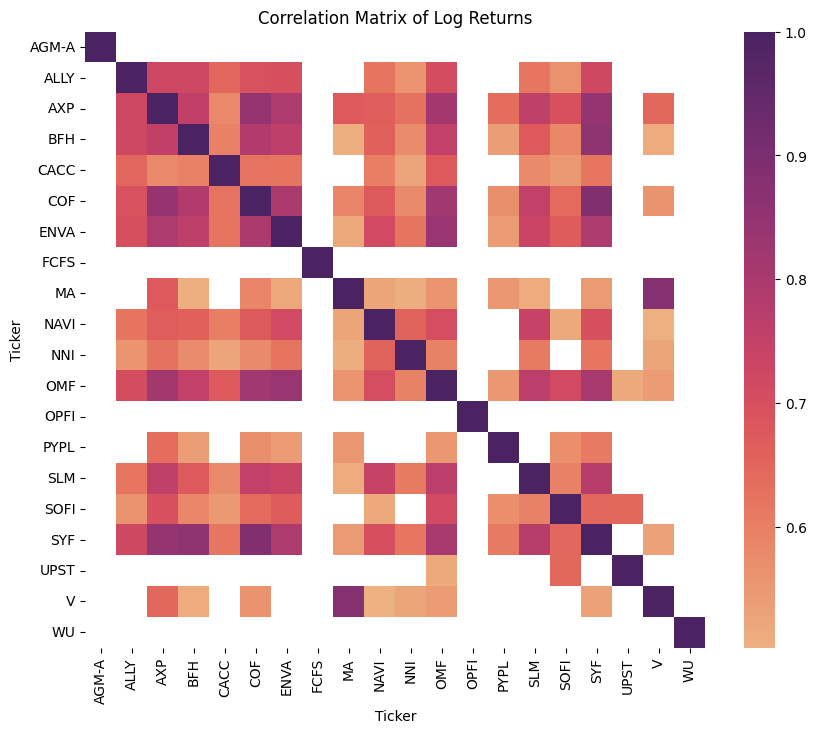

In [100]:
# plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='flare', mask=(corr_matrix<0.50))

plt.title('Correlation Matrix of Log Returns')
plt.show()

In [101]:
correlated_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        ticker1 = corr_matrix.columns[i]
        ticker2 = corr_matrix.columns[j]

        correlation = corr_matrix[ticker1][ticker2]
        if correlation > 0.50:
            correlated_pair = (ticker1, ticker2)
            correlated_pairs.append(correlated_pair)

In [102]:
correlated_pairs

[('ALLY', 'AXP'),
 ('ALLY', 'BFH'),
 ('ALLY', 'CACC'),
 ('ALLY', 'COF'),
 ('ALLY', 'ENVA'),
 ('ALLY', 'NAVI'),
 ('ALLY', 'NNI'),
 ('ALLY', 'OMF'),
 ('ALLY', 'SLM'),
 ('ALLY', 'SOFI'),
 ('ALLY', 'SYF'),
 ('AXP', 'BFH'),
 ('AXP', 'CACC'),
 ('AXP', 'COF'),
 ('AXP', 'ENVA'),
 ('AXP', 'MA'),
 ('AXP', 'NAVI'),
 ('AXP', 'NNI'),
 ('AXP', 'OMF'),
 ('AXP', 'PYPL'),
 ('AXP', 'SLM'),
 ('AXP', 'SOFI'),
 ('AXP', 'SYF'),
 ('AXP', 'V'),
 ('BFH', 'CACC'),
 ('BFH', 'COF'),
 ('BFH', 'ENVA'),
 ('BFH', 'MA'),
 ('BFH', 'NAVI'),
 ('BFH', 'NNI'),
 ('BFH', 'OMF'),
 ('BFH', 'PYPL'),
 ('BFH', 'SLM'),
 ('BFH', 'SOFI'),
 ('BFH', 'SYF'),
 ('BFH', 'V'),
 ('CACC', 'COF'),
 ('CACC', 'ENVA'),
 ('CACC', 'NAVI'),
 ('CACC', 'NNI'),
 ('CACC', 'OMF'),
 ('CACC', 'SLM'),
 ('CACC', 'SOFI'),
 ('CACC', 'SYF'),
 ('COF', 'ENVA'),
 ('COF', 'MA'),
 ('COF', 'NAVI'),
 ('COF', 'NNI'),
 ('COF', 'OMF'),
 ('COF', 'PYPL'),
 ('COF', 'SLM'),
 ('COF', 'SOFI'),
 ('COF', 'SYF'),
 ('COF', 'V'),
 ('ENVA', 'MA'),
 ('ENVA', 'NAVI'),
 ('ENVA', 'NNI'

In [103]:
len(correlated_pairs)

92

# Compute Cointegration
Test for cointegration using the Engle-Granger two step method. Cointegration is tested on the stock prices.

In [111]:
# perform linear regression
n = len(ticker_list)
pvalues = pd.DataFrame(np.ones((n, n)), index=ticker_list, columns=ticker_list)
for ticker1, ticker2 in correlated_pairs:
    result = coint(data_close[ticker1], data_close[ticker2])
    if result[1] < 0.05:
        pvalues.loc[ticker1, ticker2] = result[1]
        print('PAIR FOUND: ', ticker1, ticker2, result[1])

pvalues

PAIR FOUND:  COF SOFI 0.03358113751433614
PAIR FOUND:  NNI SLM 0.04264629816483601
PAIR FOUND:  NNI V 0.03463309166397324
PAIR FOUND:  OMF SOFI 0.04276941653657292
PAIR FOUND:  OMF SYF 0.03774874916517654


,V,MA,AXP,COF,PYPL,SYF,SOFI,ALLY,UPST,OMF,SLM,CACC,FCFS,NNI,BFH,ENVA,WU,NAVI,AGM-A,OPFI
V,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
MA,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AXP,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
COF,1.000000,1.0,1.0,1.0,1.0,1.000000,0.033581,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
PYPL,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
SYF,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
SOFI,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ALLY,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
UPST,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
OMF,1.000000,1.0,1.0,1.0,1.0,0.037749,0.042769,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


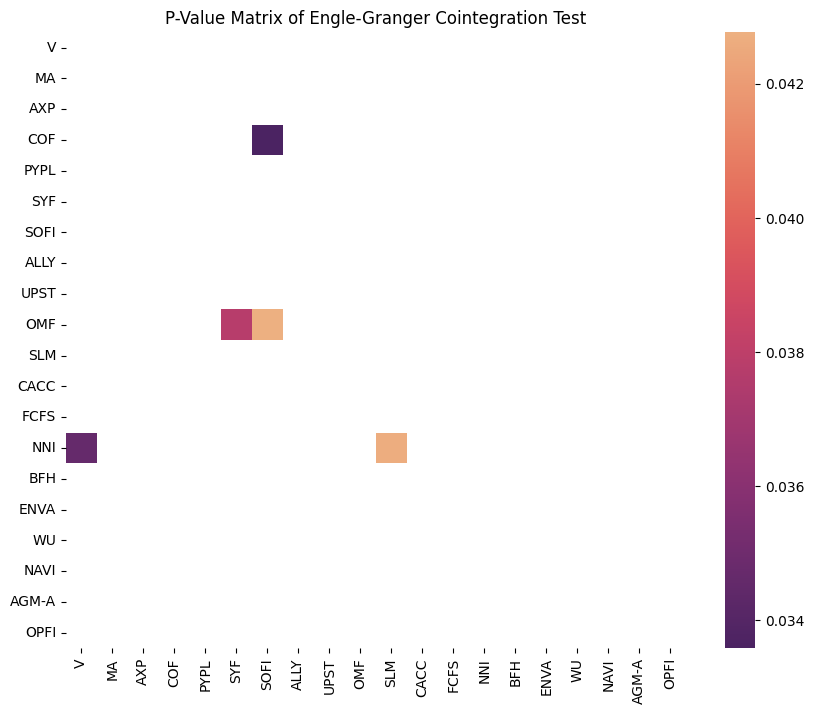

In [112]:
# heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pvalues, cmap='flare_r', mask=pvalues>=0.05)
plt.title('P-Value Matrix of Engle-Granger Cointegration Test')
plt.show()